In [ ]:
!pip install scanpy leidenalg igraph gseapy networkx pyvis scvi-tools scib_metrics muon celltypist pymde

In [ ]:
!pip install --user scikit-misc

In [75]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import leidenalg
import igraph as ig
import scanpy.external as sce
import networkx as nx
from pyvis.network import Network
from itertools import combinations
import gseapy as gp
from matplotlib.pyplot import rc_context

import os
import tempfile
import scvi
import anndata
import muon
import pooch
import torch
from rich import print
from scib_metrics.benchmark import Benchmarker

import sys
sys.path.append('/root/.local/lib/python3.10/site-packages')
import skmisc

import celltypist
from celltypist import models

In [16]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.1.2


In [25]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [58]:
!wget https://cf.10xgenomics.com/samples/spatial-exp/2.1.0/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5
path_h5 = "/content/CytAssist_FFPE_Protein_Expression_Human_Glioblastoma_raw_feature_bc_matrix.h5"

In [ ]:
adata = sc.read_10x_h5(path_h5)
adata.var_names_make_unique()


ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

sc.pp.filter_cells(adata, min_genes=200)   #get rid of cells with fewer than 200 genes
sc.pp.filter_genes(adata, min_cells=3)     #get rid of genes that are found in fewer than 3 cells

adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
lower_lim = np.quantile(adata.obs.n_genes_by_counts.values, .02)

adata = adata[(adata.obs.n_genes_by_counts < upper_lim) & (adata.obs.n_genes_by_counts > lower_lim)]
adata = adata[adata.obs.pct_counts_mt < 20]

sc.pp.normalize_total(adata, target_sum=1e4) #normalizing e. cell to 10,000 UMI
sc.pp.log1p(adata)

In [165]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AACAATCCGAGTGGAC-1,3317,3317,5748.0,219.0,3.810021
AACAATGGAACCACAT-1,10042,10042,61678.0,2305.0,3.737151
AACAATGTGCTCCGAG-1,2551,2551,4301.0,501.0,11.648454
AACACCAGCCTACTCG-1,1322,1322,1814.0,159.0,8.765160
AACACCATACGATAGT-1,820,820,970.0,21.0,2.164948
...,...,...,...,...,...
TGTTGGCCTGTAGCGG-1,8530,8530,39725.0,1292.0,3.252360
TGTTGGTGCGCACGAG-1,10075,10075,66135.0,1812.0,2.739850
TGTTGGTGCGCTTCGC-1,9084,9084,44828.0,2067.0,4.610958
TGTTGGTGCGGAATCA-1,8033,8033,32513.0,1011.0,3.109525


In [ ]:
adata_raw = adata.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",  #  flavor for identifying highly variable genes
    n_top_genes=1200,    # Number of top highly variable genes to select
    subset=True,
)

adata_raw.raw = adata[:, adata.var.highly_variable]

In [168]:
adata.layers['counts'] = adata.X.copy()

In [169]:
adata

AnnData object with n_obs × n_vars = 7416 × 1200
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'ribo', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
## Create an SCVI model object.


scvi.model.SCVI.setup_anndata(adata, layer="counts")

In [98]:

model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

In [100]:

# Train the scvi - Model


model.train()

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [06:55<00:00,  1.05it/s, v_num=1, train_loss_step=190, train_loss_epoch=180]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [06:55<00:00,  1.04s/it, v_num=1, train_loss_step=190, train_loss_epoch=180]


In [101]:
#  Instead of PCA we cluster using this

latent = model.get_latent_representation()

In [102]:
latent.shape

(7416, 30)

In [103]:
#   Evaluate the latent representation of each cell in the dataset
#   and add it to the AnnData object

adata.obsm['X_scVI'] = latent

In [104]:


adata.layers['scvi_normalized'] = model.get_normalized_expression(library_size = 1e4)


In [105]:


# clustering time...

sc.pp.neighbors(adata, use_rep = 'X_scVI')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution = 0.5)

In [106]:

adata.obs.head()


,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden
AACAATCCGAGTGGAC-1,3317,3317,5748.0,219.0,3.810021,0,0,4
AACAATGGAACCACAT-1,10042,10042,61678.0,2305.0,3.737151,0,0,3
AACAATGTGCTCCGAG-1,2551,2551,4301.0,501.0,11.648454,0,0,2
AACACCAGCCTACTCG-1,1322,1322,1814.0,159.0,8.765160,0,0,0
AACACCATACGATAGT-1,820,820,970.0,21.0,2.164948,0,0,0


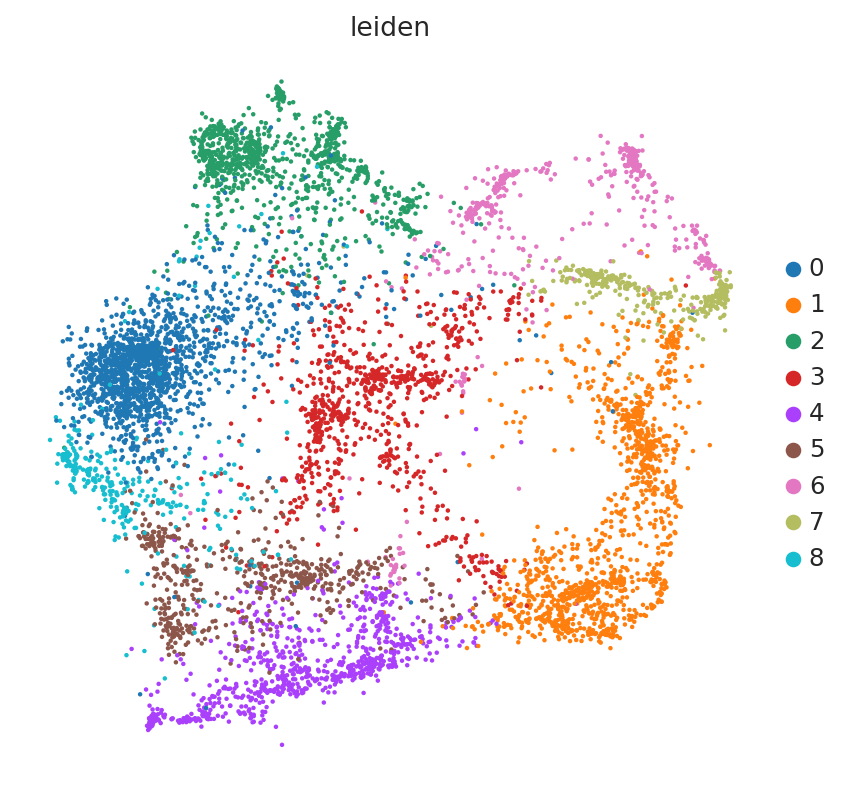

In [112]:
sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color=["leiden"], frameon=False, ncols=1)


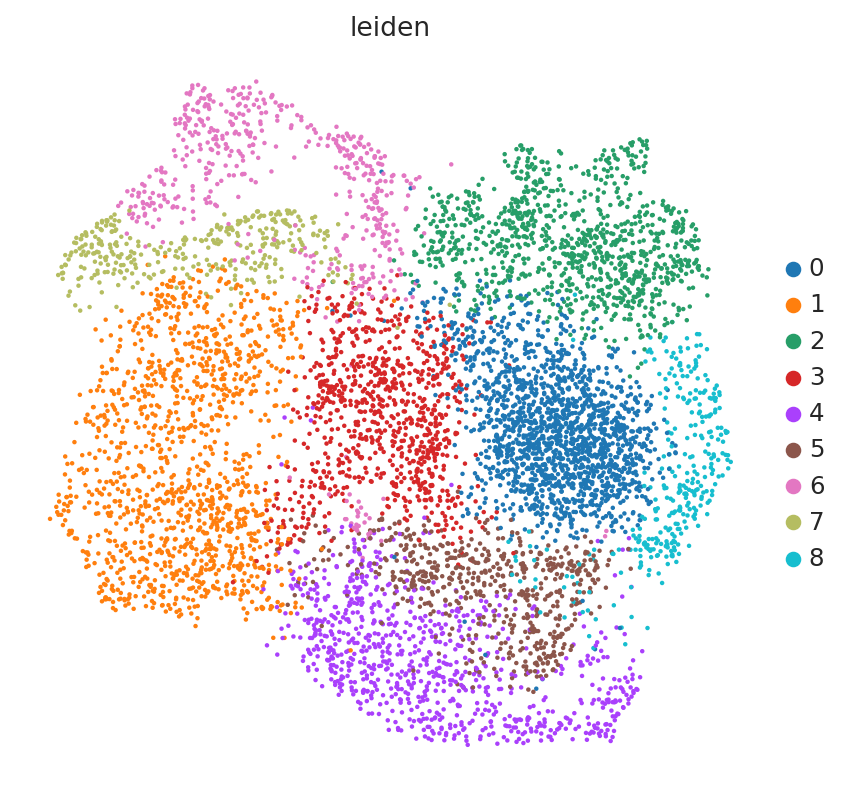

In [109]:
sc.pl.umap(adata, color = ['leiden'], frameon = False)

In [123]:
#find markers of each cluster
df = model.differential_expression(groupby = 'leiden')

df

DE...: 100%|██████████| 9/9 [00:05<00:00,  1.66it/s]


,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,...,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05,comparison,group1,group2
ATXN3L,0.9908,0.0092,4.679308,7.163244e-07,0.000009,0.0,0.25,-14.131350,-13.831482,10.360569,...,0.000000,0.001973,0.000000,0.001568,0.000000,0.116765,True,0 vs Rest,0,Rest
OR4X2,0.9902,0.0098,4.615524,2.322471e-06,0.000014,0.0,0.25,-12.608744,-12.204239,9.887095,...,0.000000,0.002300,0.000000,0.002091,0.000000,0.138691,True,0 vs Rest,0,Rest
HSD17B2,0.9902,0.0098,4.615524,1.356132e-06,0.000005,0.0,0.25,-13.243267,-12.986715,9.694776,...,0.000000,0.000978,0.000000,0.000871,0.000000,0.058107,True,0 vs Rest,0,Rest
CHAD,0.9894,0.0106,4.536244,9.077215e-07,0.000014,0.0,0.25,-12.229243,-12.143103,7.940418,...,0.002122,0.002721,0.000596,0.004705,0.258496,0.158279,True,0 vs Rest,0,Rest
RNF212B,0.9892,0.0108,4.517349,1.093615e-06,0.000006,0.0,0.25,-13.980397,-14.119173,8.996196,...,0.002336,0.000709,0.001193,0.001568,0.177404,0.039606,True,0 vs Rest,0,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,0.7040,0.2960,0.866419,2.500287e-02,0.023226,0.0,0.25,0.210527,0.237709,0.629466,...,2.837636,2.341776,1.000000,0.920333,253.228638,239.611862,False,8 vs Rest,8,Rest
PTGDS,0.6908,0.3092,0.803862,7.235163e-03,0.006959,0.0,0.25,0.211015,0.041038,1.070920,...,0.778909,0.873324,0.790123,0.724901,67.826851,72.357742,False,8 vs Rest,8,Rest
MT-ND6,0.6858,0.3142,0.780556,1.160047e-02,0.012261,0.0,0.25,0.001924,-0.104790,0.878007,...,1.210328,1.419329,0.864198,0.816977,102.837532,118.431068,False,8 vs Rest,8,Rest
MT-ND2,0.6638,0.3362,0.680275,2.509298e-02,0.023961,0.0,0.25,0.131568,0.158420,0.548688,...,2.778301,2.423612,0.996914,0.912437,248.064423,237.383759,False,8 vs Rest,8,Rest


In [ ]:
dictionary = {}

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Set the key as the index and the value as a dictionary of the row values
    dictionary[index] = row.to_dict()

# Print the resulting dictionary
#print(list(dictionary.keys()))


In [125]:
markers = {}
for c in adata.obs.leiden.cat.categories:
    cell_df = df.loc[df.group1 == c]
    markers[c] = cell_df.index.tolist()[:2]

In [126]:
markers

{'0': ['ATXN3L', 'OR4X2'],
 '1': ['MEPE', 'PNOC'],
 '2': ['TAF11L4', 'CDX4'],
 '3': ['SLC4A1', 'PF4'],
 '4': ['NLRP5', 'OR4X2'],
 '5': ['KRT76', 'TLX1'],
 '6': ['GNRHR', 'PAX5'],
 '7': ['WIF1', 'GCNT3'],
 '8': ['INHBC', 'GCNT3']}

In [79]:
!wget https://celltypist.cog.sanger.ac.uk/models/Human_Devbrain_Braun/v1/Developing_Human_Brain.pkl

--2024-06-04 00:01:30--  https://celltypist.cog.sanger.ac.uk/models/Human_Devbrain_Braun/v1/Developing_Human_Brain.pkl
Resolving celltypist.cog.sanger.ac.uk (celltypist.cog.sanger.ac.uk)... 193.62.203.62, 193.62.203.63, 193.62.203.61
Connecting to celltypist.cog.sanger.ac.uk (celltypist.cog.sanger.ac.uk)|193.62.203.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553593 (541K) [application/octet-stream]
Saving to: ‘Developing_Human_Brain.pkl’

Developing_Human_Br 100%[===================>] 540.62K   466KB/s    in 1.2s    

2024-06-04 00:01:32 (466 KB/s) - ‘Developing_Human_Brain.pkl’ saved [553593/553593]



In [170]:
modelo = models.Model.load(model = '/content/Developing_Human_Brain.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [114]:
modelo

CellTypist model with 129 cell types and 1000 features
    date: 2022-10-29 21:02:53.713593
    details: cell types from the first-trimester developing human brain
    source: https://doi.org/10.1126/science.adf1226
    version: v1
    cell types: Brain erythrocytes, Brain fibroblasts, ..., Ventral midbrain radial glia
    features: VWA1, HES5, ..., BGN

In [ ]:
modelo.cell_types

In [173]:
modelo.features[:20]

array(['VWA1', 'HES5', 'TP73', 'SLC2A5', 'C1orf127', 'TNFRSF1B', 'KAZN',
       'SRARP', 'CDA', 'ALPL', 'WNT4', 'C1QA', 'C1QC', 'C1QB', 'ID3',
       'NCMAP', 'RUNX3', 'OPRD1', 'MATN1', 'LAPTM5'], dtype=object)

In [174]:
bdata = adata.to_df()
bdata.head()

,PLEKHN1,PERM1,HES4,ISG15,TNFRSF18,ANKRD65,TMEM88B,CDK11A,CFAP74,PLCH2,...,DEPRECATED_ENSG00000220205,DEPRECATED_ENSG00000226430,DEPRECATED_ENSG00000231396,DEPRECATED_ENSG00000241794,DEPRECATED_ENSG00000243135,DEPRECATED_ENSG00000244734,DEPRECATED_ENSG00000249156,DEPRECATED_ENSG00000255974,DEPRECATED_ENSG00000278803,DEPRECATED_ENSG00000283967
AACAATCCGAGTGGAC-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
AACAATGGAACCACAT-1,0.0,0.0,0.0,0.280857,0.0,0.150257,0.0,0.0,0.0,0.0,...,0.150257,0.0,0.0,0.0,0.0,1.968654,0.0,0.0,0.0,0.0
AACAATGTGCTCCGAG-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,4.039554,0.0,0.0,0.0,0.0
AACACCAGCCTACTCG-1,0.0,0.0,0.0,1.873751,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,1.873751,0.0,0.0,0.0,0.0
AACACCATACGATAGT-1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,2.425623,0.0,0.0,0.0,0.0


In [153]:
# ANNOTATE




predictions = celltypist.annotate(adata, model='/content/Developing_Human_Brain.pkl', majority_voting=True)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [177]:
type(bdata)

pandas.core.frame.DataFrame

In [154]:



predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AACAATCCGAGTGGAC-1,Pons radial glia,18,Pons radial glia
AACAATGGAACCACAT-1,Brain fibroblasts,65,Brain fibroblasts
AACAATGTGCTCCGAG-1,Brain fibroblasts,20,Brain fibroblasts
AACACCAGCCTACTCG-1,Forebrain neuroblast,88,Brain erythrocytes
AACACCATACGATAGT-1,Hypothalamus neuron,109,Pons radial glia
...,...,...,...
TGTTGGCCTGTAGCGG-1,Brain fibroblasts,70,Pons radial glia
TGTTGGTGCGCACGAG-1,Pons OPC,10,Pons radial glia
TGTTGGTGCGCTTCGC-1,Medulla OPC,43,Brain fibroblasts
TGTTGGTGCGGAATCA-1,Forebrain neural crest cells,44,Brain fibroblasts


In [156]:
# embeddeding annot. into adata - metadata
adata = predictions.to_adata()

adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,_scvi_batch,_scvi_labels,leiden,_scvi_raw_norm_scaling,predicted_labels,over_clustering,majority_voting,conf_score
AACAATCCGAGTGGAC-1,3317,3317,5748.0,219.0,3.810021,0,0,4,130.305984,Pons radial glia,18,Pons radial glia,0.471038
AACAATGGAACCACAT-1,10042,10042,61678.0,2305.0,3.737151,0,0,3,101.863869,Brain fibroblasts,65,Brain fibroblasts,0.963303
AACAATGTGCTCCGAG-1,2551,2551,4301.0,501.0,11.648454,0,0,2,50.502270,Brain fibroblasts,20,Brain fibroblasts,0.657765
AACACCAGCCTACTCG-1,1322,1322,1814.0,159.0,8.765160,0,0,0,83.146530,Forebrain neuroblast,88,Brain erythrocytes,0.116168
AACACCATACGATAGT-1,820,820,970.0,21.0,2.164948,0,0,0,157.177780,Hypothalamus neuron,109,Pons radial glia,0.027400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTTGGCCTGTAGCGG-1,8530,8530,39725.0,1292.0,3.252360,0,0,4,130.414352,Brain fibroblasts,70,Pons radial glia,0.757364
TGTTGGTGCGCACGAG-1,10075,10075,66135.0,1812.0,2.739850,0,0,4,103.126297,Pons OPC,10,Pons radial glia,0.907205
TGTTGGTGCGCTTCGC-1,9084,9084,44828.0,2067.0,4.610958,0,0,5,110.059250,Medulla OPC,43,Brain fibroblasts,0.538775
TGTTGGTGCGGAATCA-1,8033,8033,32513.0,1011.0,3.109525,0,0,6,136.419037,Forebrain neural crest cells,44,Brain fibroblasts,0.107970


In [157]:
# let's UMAP now..
sc.tl.umap(adata)

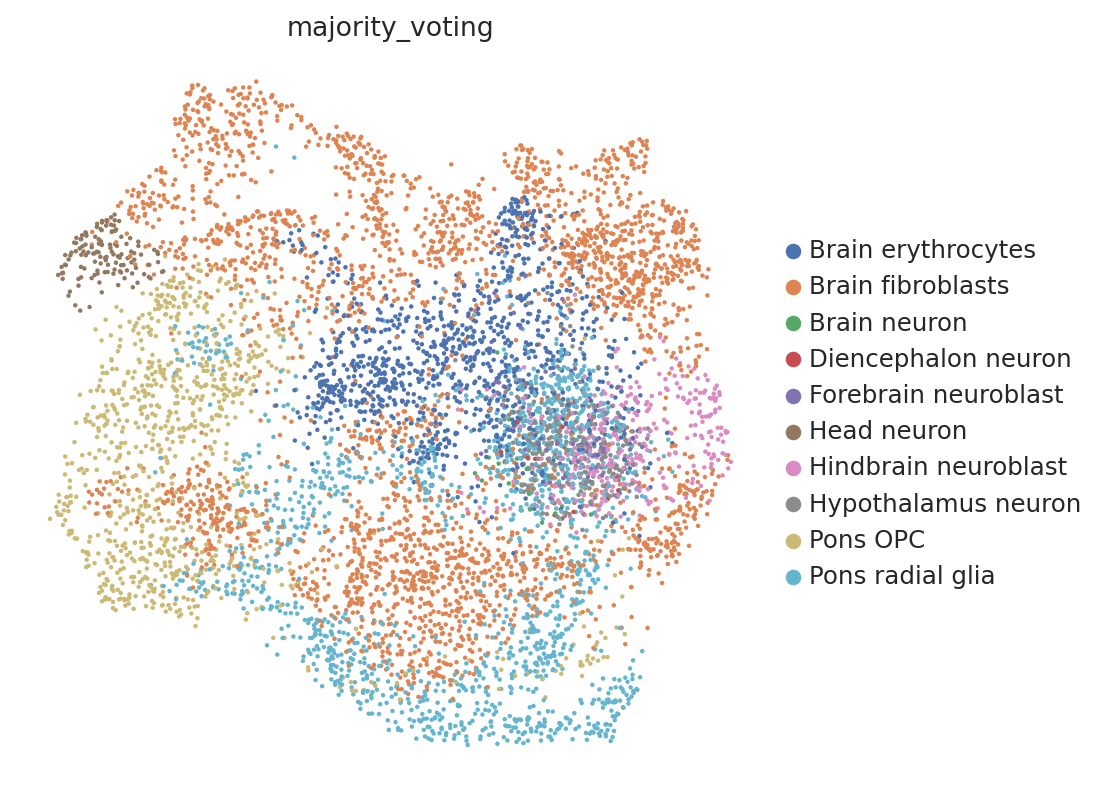

In [162]:


sc.pl.umap(adata, color = ['majority_voting'])

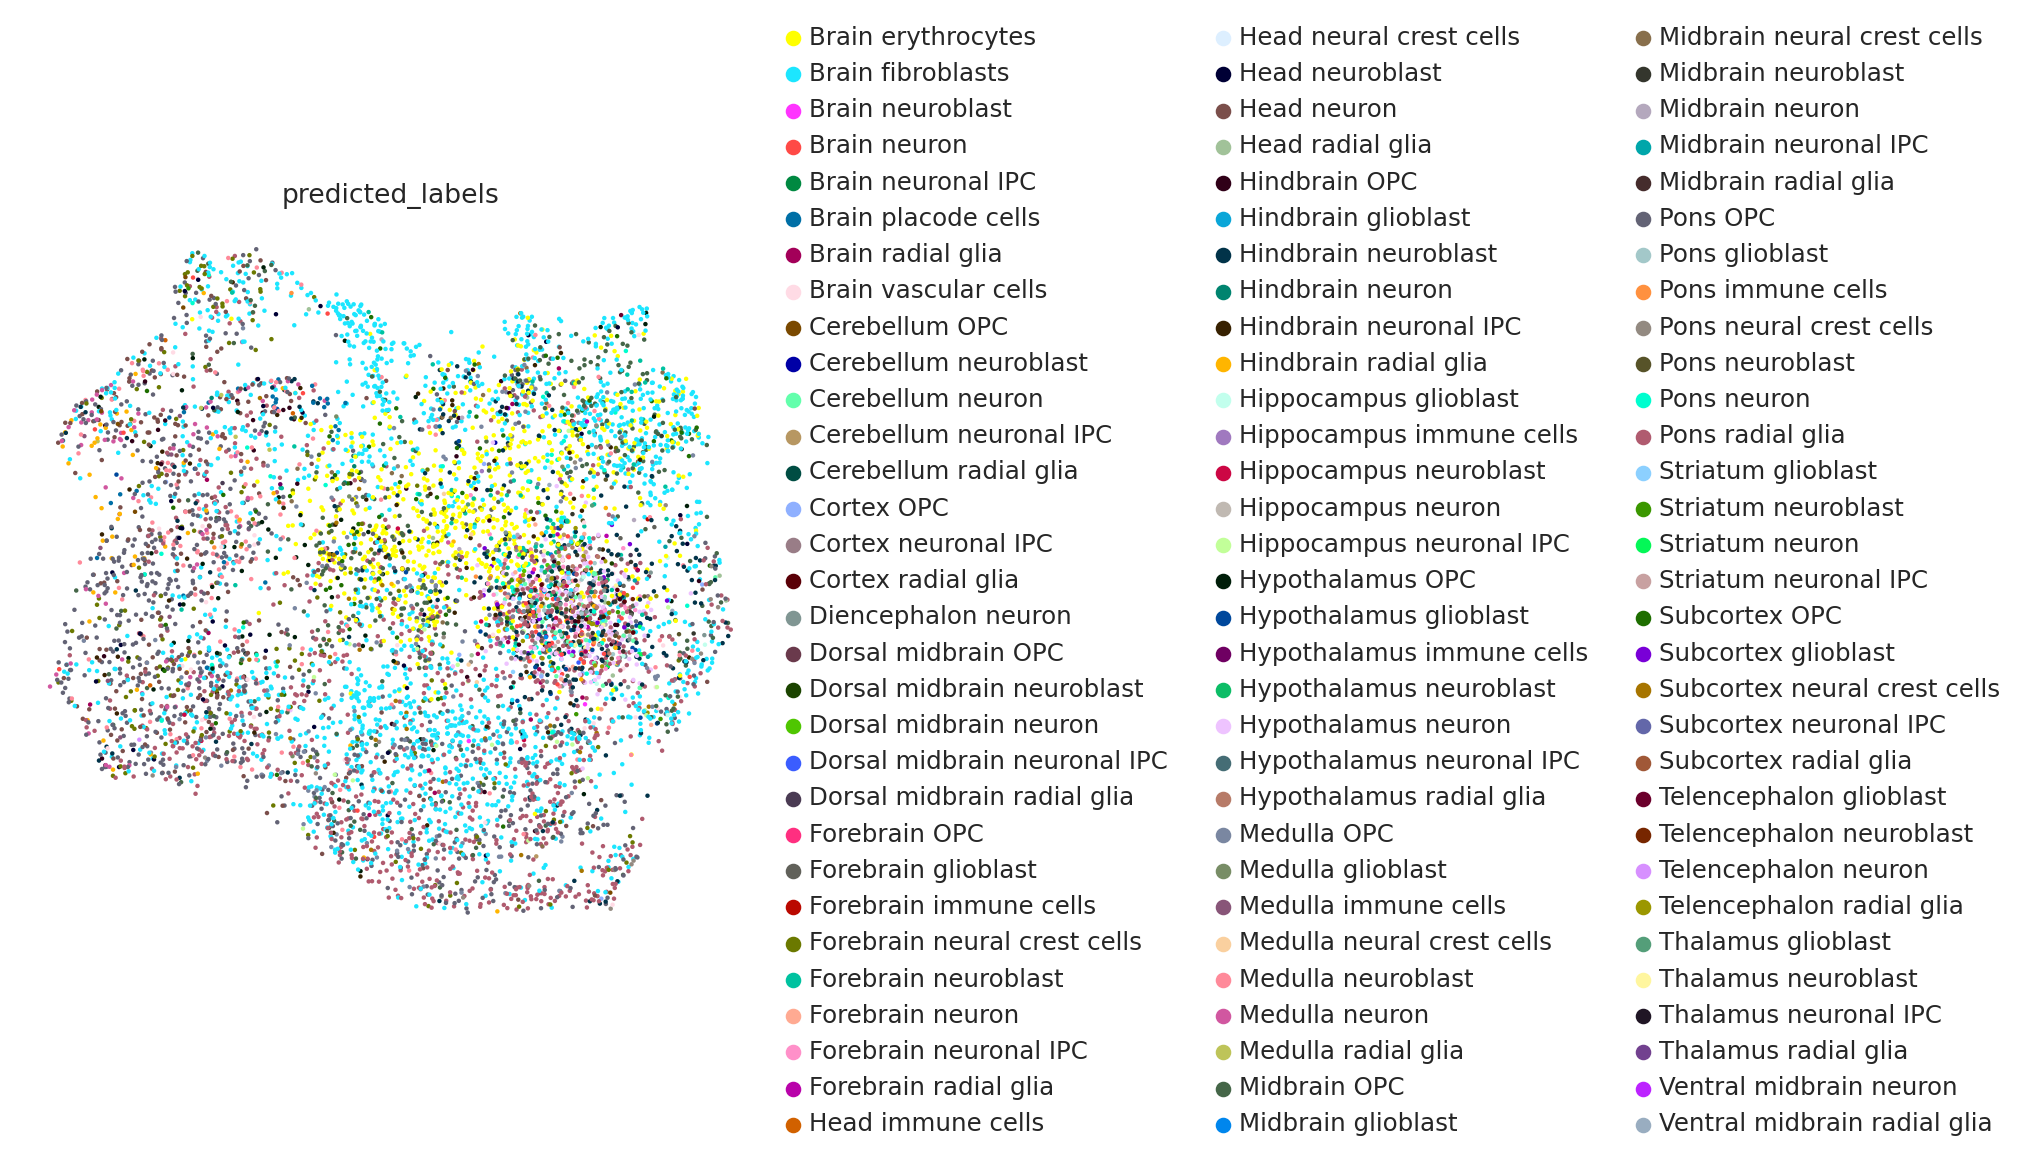

In [163]:


sc.pl.umap(adata, color = ['predicted_labels'])

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:841: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    ['Brain erythrocytes', 'Brain fibroblasts', 'Brain neuron', 'Diencephalon neuron', 'Forebrain neuroblast']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "obs")


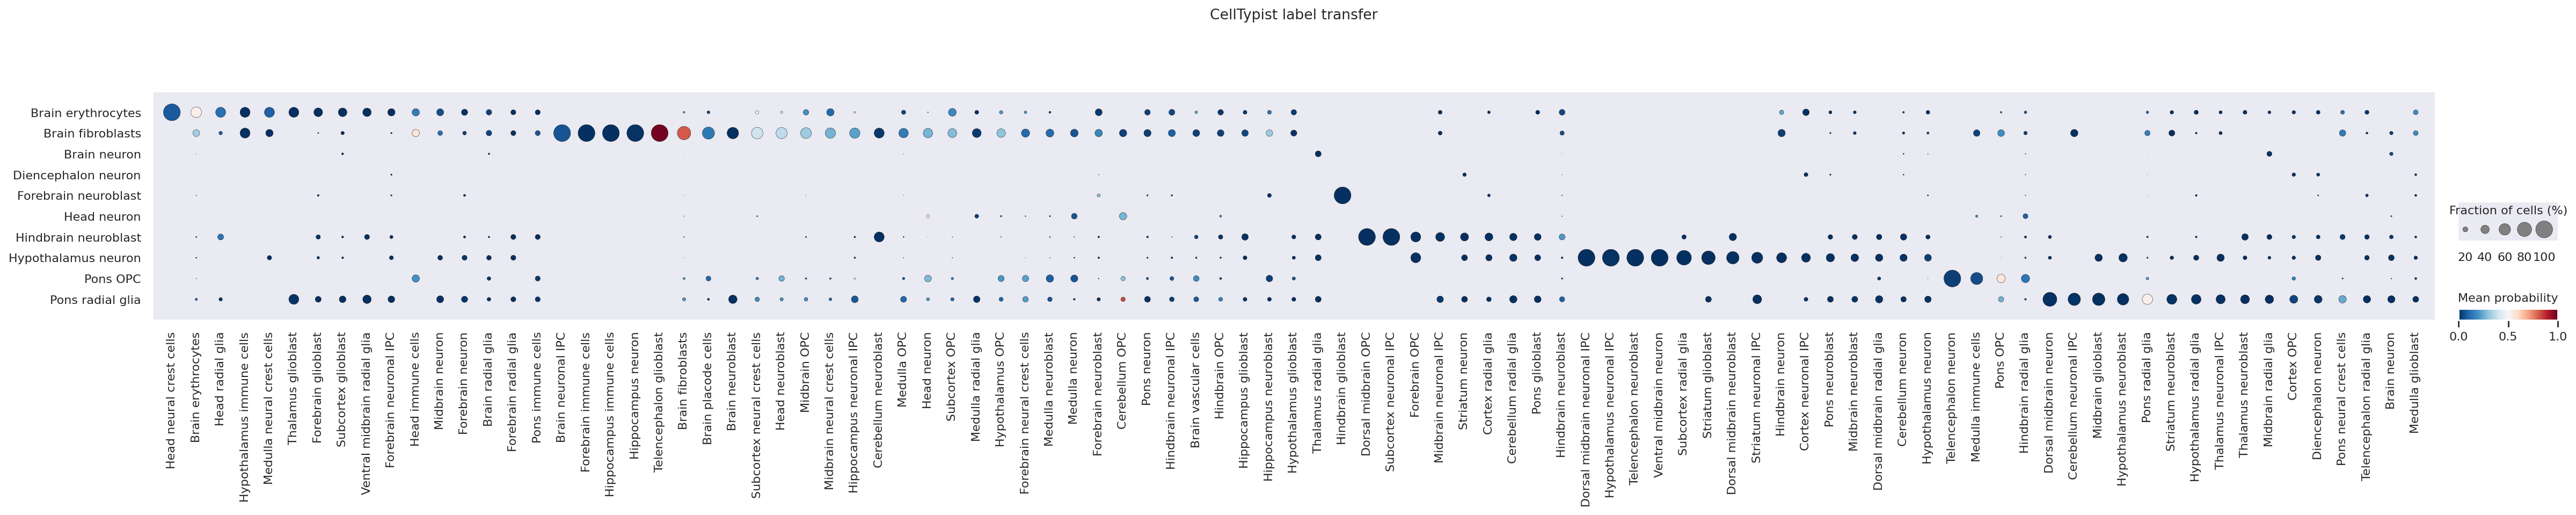

In [192]:

predicted_labels = predictions.predicted_labels
probability_matrix = predictions.probability_matrix

# Convert predicted_labels df to a list of labels
reference = predicted_labels.iloc[:, 0].tolist()

if not isinstance(probability_matrix, pd.DataFrame):
    probability_matrix = pd.DataFrame(probability_matrix)


celltypist.dotplot(predictions, use_as_reference=reference, use_as_prediction='majority_voting')


In [204]:
from google.colab import files

adata.write('/content/processed_adata.h5ad')
files.download('/content/processed_adata.h5ad')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>